# Full pipeline one step at a time

In [35]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import itertools
from tqdm import tqdm

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
from DLC_for_WBFM.utils.point_clouds.utils_bcpd import match_2vol_BCPD, match_2vol_rigid


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

# Actually import
import_opt = {'num_slices':33, 'alpha':0.15}

dat0_vid = get_single_volume(btf_fname_red, 0, **import_opt)
dat1_vid = get_single_volume(btf_fname_red, 1, **import_opt)

## First, single-volume segmentation

In [3]:
opt = {'num_slices':33, 'alpha':1.0}
# Build point clouds for each plane
all_keypoints_pcs0 = build_point_clouds_for_volume(dat0_vid, **import_opt)
all_icp0 = build_correspondence_icp(all_keypoints_pcs0)

all_keypoints_pcs1 = build_point_clouds_for_volume(dat0_vid, **import_opt)
all_icp1 = build_correspondence_icp(all_keypoints_pcs1)

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


In [4]:
all_neurons = [k.points for k in all_keypoints_pcs0]
all_matches = [m.correspondence_set for m in all_icp0]
clust_df0 = build_tracklets_from_matches(all_neurons, all_matches)

all_neurons = [k.points for k in all_keypoints_pcs1]
all_matches = [m.correspondence_set for m in all_icp1]
clust_df1 = build_tracklets_from_matches(all_neurons, all_matches)

In [5]:
# Visualize
# Build full point cloud

full_pc = o3d.geometry.PointCloud()
for pc in all_keypoints_pcs0:
    full_pc = full_pc + pc
full_pc.paint_uniform_color([0.5,0.5,0.5])

#out = visualize_clusters_from_dataframe(full_pc, clust_df0)

PointCloud with 326 points.

In [6]:
opt = {'num_slices':33, 'alpha':1.0, 'verbose':1}
neurons0, df0, icp0, pcs0 = detect_neurons_using_ICP(dat0_vid, **opt)
neurons1, df1, icp1, pcs1 = detect_neurons_using_ICP(dat1_vid, **opt)

Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons
Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons


# Next, matching two volumes via BCPD

In [31]:
from probreg import bcpd
from tqdm import tqdm
import itertools
#bcpd.registration_bcpd()

In [152]:
def test_bcp_params(pts0, pts1, params, opt={}):

    all_matches = []
    for l, k, g in tqdm(params, total=len(params)):
        bcpd_kwargs = {'lmd':l, 'k':k, 'gamma':g}
        try:
            m, all_conf = match_2vol_BCPD(C,pts1,
                                          do_zscore=True,
                                            bcpd_kwargs=bcpd_kwargs,
                                            **opt)
        except:
            counts = [0]
            m = []
        all_matches.append(m)
        
    all_counts = []
    all_overmatch = []
    for m in all_matches:
        if len(m)>0:
            vals, counts = np.unique(np.array(m)[:,1], return_counts=True)
        else:
            counts = [0]
        all_counts.append(counts)
        all_overmatch.append(max(counts))
    
    return all_counts, all_matches, all_overmatch

In [149]:
lmd_vec = [0.5, 10.0]
k_vec = [1e20]
gamma_vec = [0.1, 1.0]
params = list(itertools.product(lmd_vec,k_vec,gamma_vec))

all_counts, all_matches, all_overmatch = \
    test_bcp_params(neurons0, neurons1, params)

100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


Text(0, 0.5, '0')

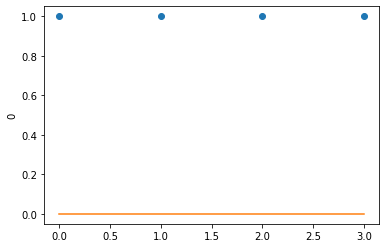

In [150]:
this_var = 0
x = [p[this_var] for p in params]
y = [len(c) for c in all_counts]
use_x = False
if use_x:
    plt.plot(x, y, 'o')
    plt.plot(x, all_overmatch, '.')
else:
    plt.plot(y, 'o')
    plt.plot(all_overmatch)
plt.ylabel(this_var)

In [148]:
which_p = 2
m = all_matches[which_p]
print("Number of matches found: ", len(m))
print(params[which_p])
if len(m)>0:
    visualize_tracks(neurons0, neurons1, m, to_plot_failed_lines=False)

Number of matches found:  0
(10.0, 1e+20, 0.1)


# Match keypoints instead of the neurons

In [174]:
from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *

ref_frames, all_matches, pairwise_matches, pairwise_conf, feature_matches = track_via_reference_frames(btf_fname_red, num_reference_frames=2)

  0%|                                                                     | 0/2 [00:00<?, ?it/s]

Pairwise matching all reference frames...


100%|█████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

WIP... aborting early


In [187]:
kp0 = ref_frames[0].keypoint_locs#[:200]
kp1 = ref_frames[1].keypoint_locs#[:200]

lmd_vec = [0.1, 1.0, 10.0]
k_vec = [1e10, 1e20]
gamma_vec = [0.1, 1.0, 10.0]
params = list(itertools.product(lmd_vec,k_vec,gamma_vec))

opt = {'voxel_size':1.0}

all_counts, all_matches, all_overmatch = \
    test_bcp_params(kp0, kp1, params, opt)

100%|███████████████████████████████████████████████████████████████████| 18/18 [00:00<?, ?it/s]


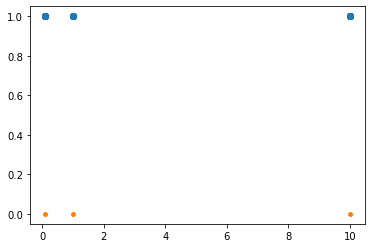

In [188]:

y = [len(c) for c in all_counts]
plt.plot(x, y, 'o')
plt.plot(x, all_overmatch, '.')


In [189]:
m = all_matches[0]
print(m)
if len(m)>0:
    visualize_tracks(kp0, kp1, m, to_plot_failed_lines=False)

[]


# Match Blobs instead of neurons

In [45]:
opt = {'num_slices':33, 'alpha':1.0, 'verbose':1}
neurons0, df0, icp0, pcs0 = detect_neurons_using_ICP(dat0_vid, **opt)
neurons1, df1, icp1, pcs1 = detect_neurons_using_ICP(dat1_vid, **opt)

Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons
Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons


In [153]:
all_pts0 = []
all_pts1 = []
start_plane = 1

for i, (p0, p1) in enumerate(zip(pcs0, pcs1)):
    if i < start_plane:
        continue
    all_pts0.extend(np.array(p0.points))
    all_pts1.extend(np.array(p1.points))

all_pts0 = np.array(all_pts0)
all_pts1 = np.array(all_pts1)

In [266]:
lmd_vec = [0.1]
k_vec = [1e10]
gamma_vec = [10.0]
params = list(itertools.product(lmd_vec,k_vec,gamma_vec))

opt = {'voxel_size':0.3, 'tf_type_name':'rigid'}

all_counts, all_matches, all_overmatch = \
    test_rigid_params(all_pts0, all_pts1, params, opt)

100%|█████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


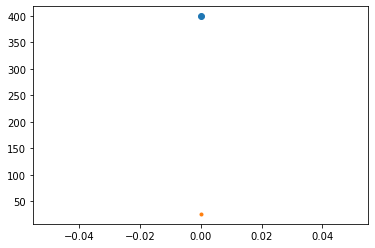

In [267]:

y = [len(c) for c in all_counts]
plt.plot(y, 'o')
plt.plot(all_overmatch, '.')


In [268]:
m = all_matches[0]
visualize_tracks(all_pts0, all_pts1, m, to_plot_failed_lines=False)

# Back to matching neurons, but just rigidly

In [259]:
def test_rigid_params(pts0, pts1, params, opt={}):

    all_matches = []
    for l, k, g in tqdm(params, total=len(params)):
        bcpd_kwargs = {'lmd':l, 'k':k, 'gamma':g}
        #try:
        m, all_conf = match_2vol_rigid(pts0,pts1,
                                            **opt)
        #except:
        #    counts = [0]
        #    m = []
        all_matches.append(m)
        
    all_counts = []
    all_overmatch = []
    for m in all_matches:
        if len(m)>0:
            vals, counts = np.unique(np.array(m)[:,1], return_counts=True)
        else:
            counts = [0]
        all_counts.append(counts)
        all_overmatch.append(max(counts))
    
    return all_counts, all_matches, all_overmatch

In [234]:
lmd_vec = [0.1]
k_vec = [1e10]
gamma_vec = [0.1]
params = list(itertools.product(lmd_vec,k_vec,gamma_vec))

opt = {'voxel_size':None, 'DEBUG':False}

all_counts, all_matches, all_overmatch = \
    test_rigid_params(neurons0, neurons1, params, opt)

100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.97it/s]


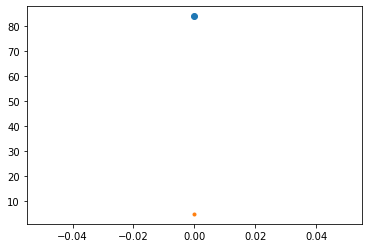

In [235]:

y = [len(c) for c in all_counts]
plt.plot(y, 'o')
plt.plot(all_overmatch, '.')


In [236]:
m = all_matches[0]
visualize_tracks(neurons0, neurons1, m, to_plot_failed_lines=False)

# Matching neurons with FilterReg

# Matching neurons, but using open3d not probreg

In [33]:
def preprocess_point_cloud(dat, voxel_size, radius_feature_factor=5, is_numpy=True, verbose=0):
    # Start with numpy array
    if is_numpy:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(dat)
    else:
        pcd = dat
    if verbose >= 1:
        print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    if verbose >= 1:
        print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * radius_feature_factor
    if verbose >= 1:
        print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size, radius_feature_factor=4.0,
                               verbose=0):
    # See http://www.open3d.org/docs/0.11.1/python_api/open3d.geometry.html
    # Note: this this a slightly old version
    distance_threshold = voxel_size * radius_feature_factor
    if verbose >= 1:
        print(":: RANSAC registration on downsampled point clouds.")
        print("   Since the downsampling voxel size is %.3f," % voxel_size)
        print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        4, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500))
    
    return result

In [8]:
voxel_size = 10.0

pc0_down, pc0_fpfh = preprocess_point_cloud(neurons0, voxel_size)
pc1_down, pc1_fpfh = preprocess_point_cloud(neurons1, voxel_size)

:: Downsample with a voxel size 10.000.
:: Estimate normal with search radius 20.000.
:: Compute FPFH feature with search radius 50.000.
:: Downsample with a voxel size 10.000.
:: Estimate normal with search radius 20.000.
:: Compute FPFH feature with search radius 50.000.


In [9]:
reg = execute_global_registration(pc0_down, pc1_down,
                                 pc0_fpfh, pc1_fpfh, voxel_size)
reg

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 10.000,
   we use a liberal distance threshold 20.000.


RegistrationResult with fitness=9.310345e-01, inlier_rmse=9.559601e+00, and correspondence_set size of 108
Access transformation to get result.

In [10]:
#draw_registration_result(pc0_down, pc1_down, reg.transformation)


In [11]:
lines = o3d.geometry.LineSet.create_from_point_cloud_correspondences(pc0_down, pc1_down, reg.correspondence_set)

o3d.visualization.draw_geometries([pc0_down, pc1_down, lines])

## Same as above, but with a subset of points

In [10]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0, 1, 0])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

print("Radius oulier removal")
cl, ind = pc0_down.remove_radius_outlier(nb_points=50, radius=100.0)
display_inlier_outlier(pc0_down, ind)

Radius oulier removal
Showing outliers (red) and inliers (gray): 


In [11]:
print("Subsampling...")
opt = {'nb_points':50, 'radius':100.0}

cl, ind = pc0_down.remove_radius_outlier(**opt)
inlier0 = pc0_down.select_by_index(ind)

cl, ind = pc1_down.remove_radius_outlier(**opt)
inlier1 = pc1_down.select_by_index(ind)

print("Building features...")
voxel_size = 10.0

_, inlier0_fpfh = preprocess_point_cloud(inlier0, voxel_size, False)
_, inlier1_fpfh = preprocess_point_cloud(inlier1, voxel_size, False)

print("Registering...")
reg = execute_global_registration(inlier0, inlier1,
                                 inlier0_fpfh, inlier1_fpfh, voxel_size)
reg

Subsampling...
Building features...
:: Downsample with a voxel size 10.000.
:: Estimate normal with search radius 20.000.
:: Compute FPFH feature with search radius 50.000.
:: Downsample with a voxel size 10.000.
:: Estimate normal with search radius 20.000.
:: Compute FPFH feature with search radius 50.000.
Registering...
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 10.000,
   we use a liberal distance threshold 20.000.


RegistrationResult with fitness=9.605263e-01, inlier_rmse=9.530082e+00, and correspondence_set size of 73
Access transformation to get result.

In [13]:
lines = o3d.geometry.LineSet.create_from_point_cloud_correspondences(inlier0, inlier1, reg.correspondence_set)

o3d.visualization.draw_geometries([inlier0, inlier1, lines])

## Geometric feature correspondence for blobs

In [12]:
all_pts0 = []
all_pts1 = []
start_plane = 1

for i, (p0, p1) in enumerate(zip(pcs0, pcs1)):
    if i < start_plane:
        continue
    all_pts0.extend(np.array(p0.points))
    all_pts1.extend(np.array(p1.points))

all_pts0 = np.array(all_pts0)
all_pts1 = np.array(all_pts1)

In [63]:
blobs = False
if blobs:
    voxel_size = 5.0

    pc0_down, pc0_fpfh = preprocess_point_cloud(all_pts0, voxel_size)
    pc1_down, pc1_fpfh = preprocess_point_cloud(all_pts1, voxel_size)
else:
    voxel_size = 1.0
    radius_feature_factor = 20.0

    pc0_down, pc0_fpfh = preprocess_point_cloud(neurons0, voxel_size, radius_feature_factor)
    pc1_down, pc1_fpfh = preprocess_point_cloud(neurons1, voxel_size, radius_feature_factor)

In [31]:
reg = execute_global_registration(pc0_down, pc1_down,
                                 pc0_fpfh, pc1_fpfh, voxel_size)
reg

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 1.000,
   we use a liberal distance threshold 4.000.


RegistrationResult with fitness=1.416667e-01, inlier_rmse=2.807679e+00, and correspondence_set size of 17
Access transformation to get result.

In [32]:
lines = o3d.geometry.LineSet.create_from_point_cloud_correspondences(pc0_down, pc1_down, reg.correspondence_set)
pc0_down.paint_uniform_color([0.5,0.5,0.5])
pc1_down.paint_uniform_color([0,0,0])

o3d.visualization.draw_geometries([pc0_down, pc1_down, lines])

## Parameter tests

In [53]:
def test_geo_features_params(pts0, pts1, params, opt={}):

    all_reg = []
    all_pc = []
    for v1, v2 in tqdm(params, total=len(params)):
        pc_kwargs = {'voxel_size':v1, 'radius_feature_factor':v2}
        try:

            pc0_down, pc0_fpfh = preprocess_point_cloud(pts0, **pc_kwargs)
            pc1_down, pc1_fpfh = preprocess_point_cloud(pts1, **pc_kwargs)
            
            all_pc.append([pc0_down, pc1_down])
            
            reg = execute_global_registration(pc0_down, pc1_down,
                                 pc0_fpfh, pc1_fpfh, **pc_kwargs)
        except:
            counts = [0]
            reg = []
        all_reg.append(reg)
        
#     all_counts = []
#     all_overmatch = []
#     for m in all_matches:
#         if len(m)>0:
#             vals, counts = np.unique(np.array(m)[:,1], return_counts=True)
#         else:
#             counts = [0]
#         all_counts.append(counts)
#         all_overmatch.append(max(counts))
    
    return all_reg, all_pc

In [64]:
voxel_sizes = list(range(1,10,2))
radius_factors = list(range(1,50,4))
params = list(itertools.product(voxel_sizes, radius_factors))

#all_reg, all_pc = test_geo_features_params(all_pts0, all_pts1, params)
all_reg, all_pc = test_geo_features_params(neurons0, neurons1, params)

100%|███████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.58it/s]


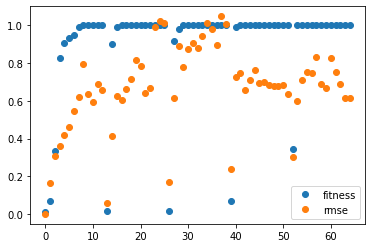

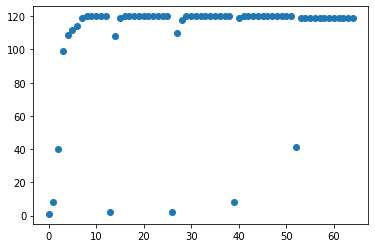

In [65]:
y1 = [r.fitness for r in all_reg]
y2 = [r.inlier_rmse/20.0 for r in all_reg]
plt.plot(y1,'o', label='fitness')
plt.plot(y2,'o', label='rmse')
plt.legend()

y3 = [len(r.correspondence_set) for r in all_reg]
plt.figure()
plt.plot(y3,'o')



In [73]:
i = 3

pc0, pc1 = all_pc[i]
reg = all_reg[i]
lines = o3d.geometry.LineSet.create_from_point_cloud_correspondences(pc0, pc1, reg.correspondence_set)

o3d.visualization.draw_geometries([pc0, pc1, lines])

## Scratch for clustering

In [48]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pc0_down.cluster_dbscan(eps=100.0, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pc0_down.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pc0_down])

[Open3D WARNING] Read PLY failed: unable to open file: ../../test_data/fragment.ply
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
point cloud has 1 clusters
